# Pretreat the coin image

## 1. Split the coin image into front and back side
  
  We need to split the coin image into front and back side. Because we will upload a coin single side. I think we should create below as folder structure:

```
├── imgs
│   ├── China_Mainland
│   │   ├── Front
│   │   │   ├── Front1.jpg
│   │   │   ├── Front2.jpg
│   │   │   ├── Front3.jpg
│   │   ├── Back
│   │   │   ├── Back1.jpg
│   │   │   ├── Back2.jpg
│   │   │   ├── Back3.jpg
│   ├── China_HongKong
│   ├── China_Macau
│   ├── China_Taiwan
```
 

In [1]:
import re
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def get_image_path_from_folder(folder_path, case_sensitive=True):
    """
    # Load all files with .jpg, .png etc type
    # If we want to load file with .jpg or .JPG type file,
    # we could change the regular expression to
    # '^.*\.(jpg|gif|png|bmp)(?i)'
    """
    store_list = []
    pattern_string = '^.*\.(jpg|gif|png|bmp)'
    get_file_path_from_folder(folder_path, store_list,
                              pattern_string, case_sensitive)
    return store_list


def get_file_path_from_folder(folder_path, store_list,
                              pattern_string, case_sensitive=True):
    """ Get all folder's file
    """

    if not case_sensitive:
        pattern_string.join('(?i)')

    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        if os.path.isdir(file_path):
            print('folder name: %s' % file_path.split('/')[-1])
            get_file_path_from_folder(file_path, store_list,
                                      pattern_string, case_sensitive)
        elif re.match(r'%s' % pattern_string, file_path):
            store_list.append(file_path)
            
def get_file_name_and_type(file_path):
    split_path = os.path.basename(file_path).split('.')
    return split_path[0], split_path[-1]


def get_folder_name_by_folder(folder_path):
    return os.path.basename(folder_path)


def get_folder_name_by_file(file_path):
    return get_folder_path_by_file(file_path).split('/')[-1]


def get_folder_path_by_file(file_path):
    return os.path.dirname(file_path)


def create_folder_with_path(folder_path):
    folder_path = os.path.abspath(folder_path)

    # Delete the initial blank space
    folder_path = folder_path.strip()

    # Delete end symbol '\'
    folder_path = folder_path.rstrip('\\')

    isExists = os.path.exists(folder_path)

    if not isExists:
        os.makedirs(folder_path)
        print('\033[0;32m%s\033[0m created success.' % folder_path)
        return True
    else:
        print('\033[0;32m%s\033[0m already created.' % folder_path)
        return False

In [3]:
base_folder = 'imgs'
image_list = get_image_path_from_folder(base_folder)

folder name: imgs\China_Mainland


(235, 470, 3)
0
235
0
235
235
470
0
235


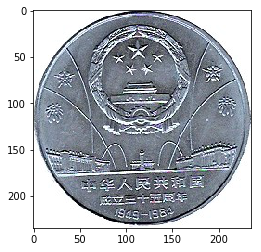

In [31]:
def split_img_area(img_mat, start_location=(0, 0), size=(2, 1)):
    '''
    @parameters 
       start_location: where start to split current image
       size: split current image to how many part
     @result
        return a list for all image area
    '''
    if size[0] < 0 or size[1] < 0:
        print('x_size or y_size can\'t allow to set zero.')
        return None
    start_x = start_location[0]
    start_y = start_location[1]
    x_area_unit = int(img_mat.shape[1] / size[0])
    y_area_unit = int(img_mat.shape[0] / size[1])
    all_area = []
    for x in range(0, size[0]):
        y_sum_area_unit = start_y + y_area_unit
        for y in range(0, size[1]):
            x_sum_area_unit = start_x + x_area_unit
            print(start_y)
            print(y_sum_area_unit)
            print(start_x)
            print(x_sum_area_unit)
            all_area.append(img_mat[start_y:y_sum_area_unit,
                                    start_x:x_sum_area_unit])
            start_x = x_sum_area_unit
            
        start_x = start_location[0]
        start_y = y_sum_area_unit
    return all_area


# for img_path in image_list:
img_path = image_list[0]
img_name, img_type = get_file_name_and_type(img_path)
img_folder_path = get_folder_path_by_file(img_path)
img = cv2.imread(img_path)
print(img.shape)
img_area_list = split_img_area(img)

plt.imshow(img[0:470, 0:235])


#     new_img_folder_path = '{}/{}'.format(img_folder_path, img_name)
#     create_folder_with_path(new_img_folder_path)
#     img_area1_path = '{}/{}.{}'.format(new_img_folder_path, 1, img_type)
#     cv2.imwrite(img_area1_path, img_area_list[0])
#     print('{} saved.'.format(img_area1_path))
#     img_area2_path = '{}/{}.{}'.format(new_img_folder_path, 2, img_type)
#     cv2.imwrite(img_area2_path, img_area_list[1])
#     print('{} saved.'.format(img_area2_path))

7


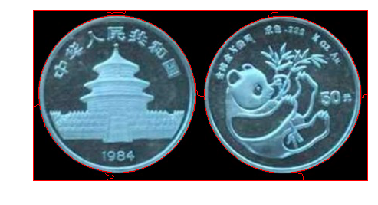

(223, 437)
(223, 437)


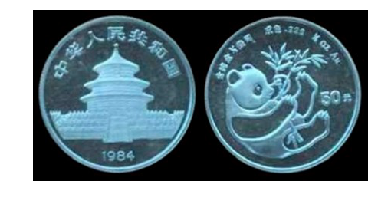

In [34]:
fig = plt.figure()
image = cv2.imread('./imgs/China_Mainland/km90_50_Yuan_(1984)_Temple_of_Heaven.jpg')

img = image.copy()
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2) # 形态开运算

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)


# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

print(ret)
# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0
markers = cv2.watershed(img, markers)
img[markers == -1] = [255,0,0]

# plt.subplot(221)
# plt.axis('off')
# plt.imshow(markers, cmap='gray')
# plt.subplot(222)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

print(gray.shape)
print(markers.shape)
plt.imshow(gray)
plt.axis('off')
# image = cv2.add(gray, markers)
plt.imshow(image)

(223, 437)
(223, 437)


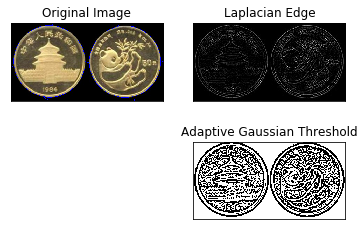

In [22]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
################################################################################
 
# print 'Load Image'
 
# imgFile = 'images/big_alice.jpg'
 
# load an original image
# img = cv2.imread(imgFile)
################################################################################
# color value range
cRange = 256
 
# rows,cols,channels = img.shape
 
# convert color space from bgr to gray
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
################################################################################
 
# laplacian edge
imgLap = cv2.Laplacian(gray,cv2.CV_8U)
 
# otsu method
# threshold,imgOtsu = cv2.threshold(gray,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print(markers.shape)
print(gray.shape)
# adaptive gaussian threshold  
imgAdapt = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
# imgAdapt = cv2.medianBlur(imgAdapt, 3)    
################################################################################
 
# display original image and gray image
plt.subplot(2,2,1), plt.imshow(img), plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2), plt.imshow(imgLap,cmap = 'gray'), plt.title('Laplacian Edge'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4), plt.imshow(imgAdapt,cmap = 'gray'), plt.title('Adaptive Gaussian Threshold'), plt.xticks([]), plt.yticks([])
plt.show()     

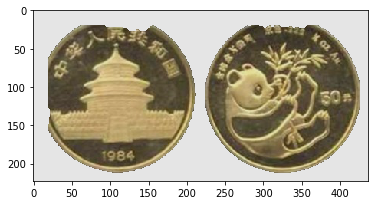

In [23]:
img = img
mask = np.zeros(img.shape[:2], np.uint8)
 
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)
 
rect = (20, 20, 413, 591)
cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 10, cv2.GC_INIT_WITH_RECT)
 
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
img = img * mask2[:, :, np.newaxis]
img += 255 * (1 - cv2.cvtColor(mask2, cv2.COLOR_GRAY2BGR))
# plt.imshow(img)
# plt.show()
img = np.array(img)
mean = np.mean(img)
img = img - mean
img = img * 0.9 + mean * 0.9
img /= 255
plt.imshow(img)
plt.show()

In [ ]:
def image_matting(self, image_file, shape, iteration=10):
    points = shape['points']
    xmin, ymin, xmax, ymax = Grab_cut.convertPoints2BndBox(points)
    self.width = xmax - xmin
    self.height = ymax - ymin

    src_img = cv2.imread(image_file)

    mask = np.zeros(src_img.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (xmin, ymin, self.width, self.height)

    # Grabcut
    cv2.grabCut(src_img, mask, rect, bgdModel, fgdModel,
                iteration, cv2.GC_INIT_WITH_RECT)

    r_channel, g_channel, b_channel = cv2.split(src_img)
    a_channel = np.where((mask == 2) | (mask == 0), 0, 255).astype('uint8')

    # crop image space
    for row in range(ymin, ymax):
        if sum(r_channel[row, xmin:xmax + 1]) > 0:
            out_ymin = row
            break
    for row in range(ymin, ymax)[::-1]:
        if sum(r_channel[row, xmin:xmax + 1]) > 0:
            out_ymax = row + 1
            break
    for col in range(xmin, xmax):
        if sum(a_channel[ymin:ymax + 1, col]) > 0:
            out_xmin = col
            break
    for col in range(xmin, xmax)[::-1]:
        if sum(a_channel[ymin:ymax + 1, col]) > 0:
            out_xmax = col + 1
            break

    # output image
    img_RGBA = cv2.merge((r_channel[out_ymin:out_ymax, out_xmin:out_xmax],
                          g_channel[out_ymin:out_ymax, out_xmin:out_xmax],
                          b_channel[out_ymin:out_ymax, out_xmin:out_xmax],
                          a_channel[out_ymin:out_ymax, out_xmin:out_xmax]))

    return img_RGBA

In [ ]:
def rotate_whole_img(self, img):
        """
           rotate noise
           rotate angle is 0 - 20
        """
        angle = np.random.randint(0,20)
        h, w = img.shape[:2]
        center = (w / 2, h / 2)
        M = cv2.getRotationMatrix2D(center, angle, 1)
        im = cv2.warpAffine(img, M, (w,h), borderValue=(255,255,255))
        return im

In [ ]:
def search_outline(bins):
    '''搜寻符合条件的轮廓，根据轮廓得到截图集合'''
    width = len(bins[0])
    height = len(bins)
    area = width * height
    cropImageDict = {} #用于保存根据轮廓截取的图片
    expImageDict = {} #用于保存特字符，如I，1
    hSum = 0  #总高度
    wSum = 0  #总宽度
    min_area = area / NOISE_FACTOR
    img, cnts, hierarchy = cv2.findContours(bins, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    '''说明：cnts中的每一个元素cn是一个列表，形状为(n,1,2),即有n个元素，每个元素是[[x,y]]的形式'''
    for i in range(0,len(cnts)):
        cn = cnts[i]
        x,y,w,h = cv2.boundingRect(cn)
        '''说明：boundingRect能够得到包裹轮廓cn的直矩形(不是最小内接矩形)，
        x,y分别是矩形左上点的横坐标和纵坐标，w,h分别是矩形的宽和高'''
        if x * y > min_area and hierarchy[0][i][3] == -1:  #hierarchy[0][i][3] == -1表示不属于任何轮廓
            scope = [x, x + w - 1, y, y + h - 1]  # (x+w-1,y+h-1)表示直矩形右下点的坐标
            image = crop_image(bins, scope)
            if h / w < NARROW_FACTOR: #高与宽的比值小于某个范围，认为是正常的字符，否则是特殊字符
                hSum += h
                wSum += w
                cropImageDict[i] = image
            else:
                expImageDict[i] = image
    '''计算平均宽度和平均高度'''
    wMean = wSum / len(cropImageDict)
    hMean = hSum / len(cropImageDict)
    '''对异常的字符截图加上黑色边框'''
    for k in expImageDict:
        expImg = expImageDict[k]
        correctImg = add_width(wMean,expImg)
        cropImageDict[k] = correctImg
    return cropImageDict, wMean, hMean

In [ ]:
for i in circles[0,:]:
        cv2.circle(roi,(i[0],i[1]),i[2],(0,255,0),2)
#         cv2.circle(roi,(i[0], i[1]),2, (0,0,255), 3)
#         radius = i[2]
#         ratio = ((radius*radius) / (largestRadius*largestRadius))
#         if(ratio >= 0.85):
#             change = change + 1
#         elif((ratio >=.68) and (ratio<=0.85)):
#             change = change + 0.5
#         elif((ratio >= 0.60) and (ratio<.68)):
#             change = change + 0.25
#         elif((ratio >= 0.40) and (ratio<0.60)):
#             change = change + 0.1
#         elif(ratio < 0.40):
#             change = change + 0.05
# print(change)
# font = cv2.FONT_HERSHEY_SIMPLEX
# text = "Total value: " + str("%.2f" % round(change,2)) + " turkish lira"
# cv2.putText(roi, text, (0,400), font, 0.5, (0, 0, 0), 2, cv2.LINE_AA)
plt.imshow(roi)

In [ ]:
# encoding:utf-8
# 图像提取
# create by 
 

img = cv2.imread('./imgs/China_Mainland/km1_1_Fen_(1955-2011)_aluminum.jpg')
mask = np.zeros(img.shape[:2], np.uint8)
 
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)
 
rect = (20, 20, 413, 591)
cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 10, cv2.GC_INIT_WITH_RECT)
 
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
img = img * mask2[:, :, np.newaxis]
img += 255 * (1 - cv2.cvtColor(mask2, cv2.COLOR_GRAY2BGR))
# plt.imshow(img)
# plt.show()
img = np.array(img)
mean = np.mean(img)
img = img - mean
img = img * 0.9 + mean * 0.9
img /= 255
plt.imshow(img)
plt.show()